In [1]:
pip install deepface

Note: you may need to restart the kernel to use updated packages.


In [9]:
!pip install ipykernel
!python -m ipykernel install --user --name=tf215 --display-name "Python (tf215)"

Installed kernelspec tf215 in C:\Users\90553\AppData\Roaming\jupyter\kernels\tf215


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


In [11]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install tf-keras

Note: you may need to restart the kernel to use updated packages.


In [15]:
pip install tensorflow keras

Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install kafka-python

In [87]:
# Importing libraries
import azure
import seaborn as sns
import io
import gc
from azure.storage.blob import BlobClient, BlobServiceClient, ContainerClient
from keras import utils
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras import mixed_precision
from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64
import matplotlib.image as mpimg
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import time
import json
import random
from tqdm import tqdm
from deepface import DeepFace
from io import StringIO
import networkx as nx
from kafka import KafkaProducer
from scipy.spatial.distance import cosine
from sklearn.metrics import f1_score
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from collections import deque, defaultdict

### Local Gender Detection Part

In [90]:
main_folder = r"C:\Users\90553\Desktop\bigdata kodlari\New folder\img_align_celeba\img_align_celeba"
images_folder = main_folder
EXAMPLE_PIC = os.path.join(images_folder, '000001.jpg') 

TRAINING_SAMPLES = 10000
VALIDATION_SAMPLES = 2000
TEST_SAMPLES = 2000
IMG_WIDTH = 178
IMG_HEIGHT = 218
BATCH_SIZE = 16
NUM_EPOCHS = 20

In [92]:
df_attr = pd.read_csv('list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True)
print(df_attr.shape)

(202599, 40)


In [94]:
# List of available attributes
for i, j in enumerate(df_attr.columns):
    print(i, j)

0 5_o_Clock_Shadow
1 Arched_Eyebrows
2 Attractive
3 Bags_Under_Eyes
4 Bald
5 Bangs
6 Big_Lips
7 Big_Nose
8 Black_Hair
9 Blond_Hair
10 Blurry
11 Brown_Hair
12 Bushy_Eyebrows
13 Chubby
14 Double_Chin
15 Eyeglasses
16 Goatee
17 Gray_Hair
18 Heavy_Makeup
19 High_Cheekbones
20 Male
21 Mouth_Slightly_Open
22 Mustache
23 Narrow_Eyes
24 No_Beard
25 Oval_Face
26 Pale_Skin
27 Pointy_Nose
28 Receding_Hairline
29 Rosy_Cheeks
30 Sideburns
31 Smiling
32 Straight_Hair
33 Wavy_Hair
34 Wearing_Earrings
35 Wearing_Hat
36 Wearing_Lipstick
37 Wearing_Necklace
38 Wearing_Necktie
39 Young


Attractive    1
Male          0
Young         1
Name: 000001.jpg, dtype: int64


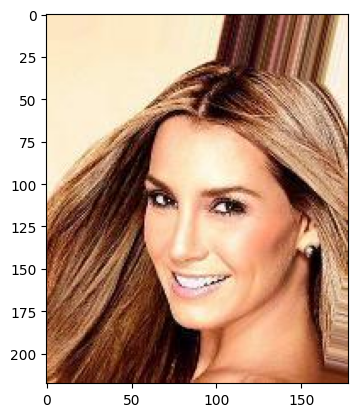

In [96]:
img = load_img(EXAMPLE_PIC)
plt.grid(False)
plt.imshow(img)

image_id = os.path.basename(EXAMPLE_PIC)  # '000001.jpg'
print(df_attr.loc[image_id][['Attractive', 'Male', 'Young']])


In [100]:
# Recommended partition
df_partition = pd.read_csv('list_eval_partition.csv')
df_partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [102]:
# Join the partition with the attributes
df_partition.set_index('image_id', inplace=True)
df_par_attr = df_partition.join(df_attr['Male'], how='inner')
df_par_attr.head()

,partition,Male
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,0,1
000004.jpg,0,0
000005.jpg,0,0


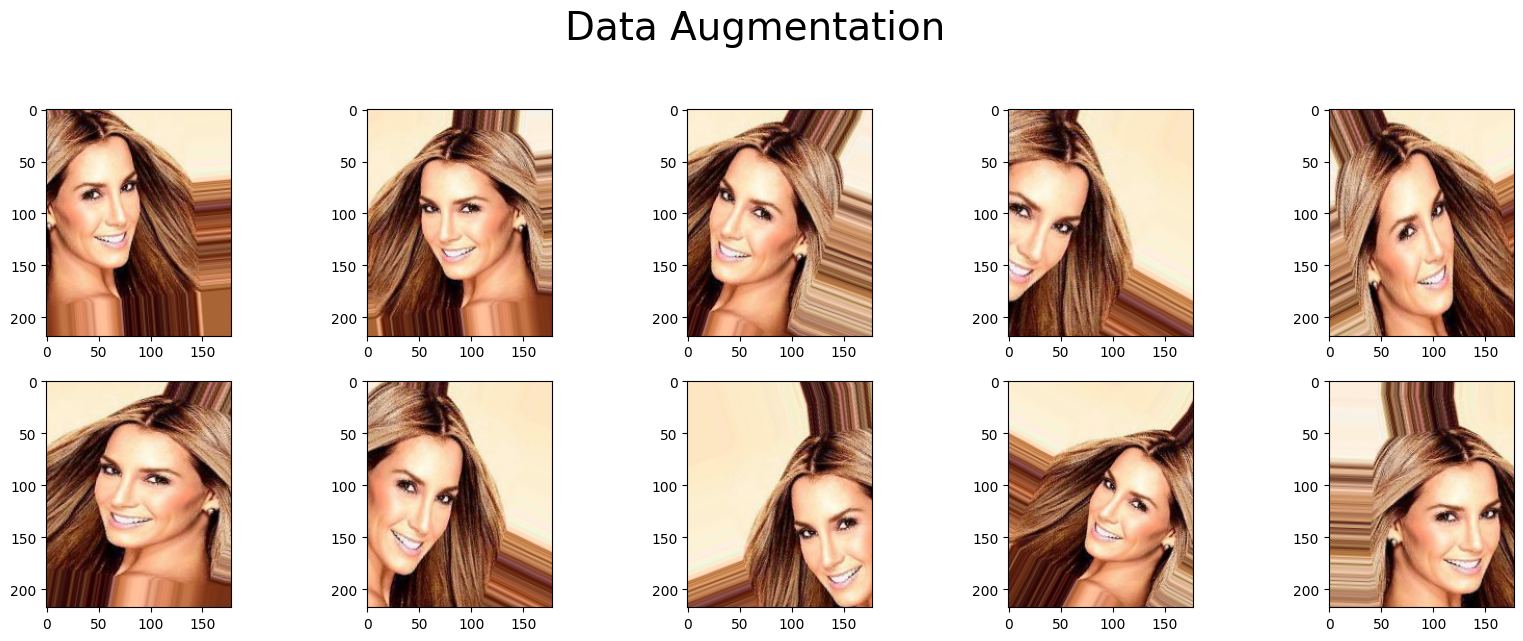

In [104]:
# Generate image generator for data augmentation
datagen =  ImageDataGenerator(
  #preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

# load one image and reshape
img = load_img(EXAMPLE_PIC)
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)

# plot 10 augmented images of the loaded iamge
plt.figure(figsize=(20,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow( batch.reshape(218, 178, 3))

    if i == 9:
        break
    i += 1

plt.show()

In [106]:
# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

df_train = df_par_attr[df_par_attr['partition'] == 0].reset_index()
df_valid = df_par_attr[df_par_attr['partition'] == 1].reset_index()

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [108]:
df_train["Male"] = df_train["Male"].astype(str)
df_valid["Male"] = df_valid["Male"].astype(str)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=images_folder,
    x_col="image_id",
    y_col="Male",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=df_valid,
    directory=images_folder,
    x_col="image_id",
    y_col="Male",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)


Found 162770 validated image filenames belonging to 2 classes.
Found 19867 validated image filenames belonging to 2 classes.


In [109]:
# Import InceptionV3 Model
inc_model = InceptionV3(weights=None,
                        include_top=False,
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

print("number of layers:", len(inc_model.layers))

number of layers: 311


In [112]:
# Adding custom Layers
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

In [114]:
# Creating the final model
model_ = Model(inputs=inc_model.input, outputs=predictions)

# Freezing initial layers
for layer in model_.layers[:52]:
    layer.trainable = False

# Compiling the model
model_.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

In [116]:
# Saving best weights into a file to reuse it later
checkpointer = ModelCheckpoint(filepath='weights.best.inc.male.hdf5.keras',
                               verbose=1, save_best_only=True)

In [ ]:
# Running the model
hist = model_.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=NUM_EPOCHS,
    callbacks=[checkpointer],
    verbose=1
)

In [ ]:
# Displaying the train and validation accuracies
# with respect to number of epochs the model trained
plt.figure(figsize=(18, 4))
plt.plot(hist.history['accuracy'], label = 'train')
plt.plot(hist.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

In [206]:


save_folder = r"C:\Users\90553\Desktop\deneme"
os.makedirs(save_folder, exist_ok=True)

attr_csv_path = r"C:\Users\90553\Desktop\New folder (4)\list_attr_celeba_with_reciprocal_friends_updated.csv"
df = pd.read_csv(attr_csv_path)

required_columns = ['image_id', 'friend1_id', 'friend2_id', 'Attractive', 'Male', 'Young']
for col in required_columns:
    if col not in df.columns:
        df[col] = pd.NA

start_id = 202600

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
cap = cv2.VideoCapture(0)

start_time = time.time()
faces_detected = False
faces_frame = None

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 5)

    if len(faces) >= 1:
        faces_detected = True
        faces_frame = (frame.copy(), faces)
        break

    if time.time() - start_time > 60:
        print("No face detected within 60 seconds. Exiting...")
        break

new_entries = []

if faces_detected:
    time.sleep(3)
    img, faces = faces_frame
    positions = []

    if len(faces) == 1:
        (x, y, w, h) = faces[0]
        cropped_face = img[y:y+h, x:x+w]
        filename = f"{start_id}.jpg"
        save_path = os.path.join(save_folder, filename)
        cv2.imwrite(save_path, cropped_face)

        entry = {
            'image_id': filename,
            'friend1_id': pd.NA,
            'friend2_id': pd.NA,
            'Attractive': 0,
            'Male': 0,
            'Young': 0
        }
        new_entries.append(entry)
        print(f"One face saved: {filename}")
        start_id += 1

    elif len(faces) >= 2:
        for (x, y, w, h) in faces[:2]:
            cropped_face = img[y:y+h, x:x+w]
            filename = f"{start_id}.jpg"
            save_path = os.path.join(save_folder, filename)
            cv2.imwrite(save_path, cropped_face)

            entry = {
                'image_id': filename,
                'friend1_id': pd.NA,
                'friend2_id': pd.NA,
                'Attractive': 0,
                'Male': 0,
                'Young': 0
            }
            positions.append((x + w//2, y + h//2))
            new_entries.append(entry)
            print(f"Face saved: {filename}")
            start_id += 1

        dist = ((positions[0][0] - positions[1][0])**2 + (positions[0][1] - positions[1][1])**2)**0.5
        if dist < 250:
            new_entries[0]['friend1_id'] = new_entries[1]['image_id']
            new_entries[1]['friend1_id'] = new_entries[0]['image_id']
            print("Faces are close to each other, assigned as friend1.")

cap.release()

if new_entries:
    df_new = pd.DataFrame(new_entries)
    df = pd.concat([df, df_new], ignore_index=True)

    save_csv_path = r"C:\Users\90553\Desktop\New folder (4)\list_attr_celeba_with_reciprocal_friends_updatedCameraChecked.csv"
    df.to_csv(save_csv_path, index=False)

    print("New face(s) saved and added to CSV file:")
    print(save_csv_path)
    print(df.tail(len(df_new))[['image_id', 'friend1_id']])
else:
    print("No new faces added.")


Face saved: 202600.jpg
Face saved: 202601.jpg
Faces are close to each other, assigned as friend1.
New face(s) saved and added to CSV file:
C:\Users\90553\Desktop\New folder (4)\list_attr_celeba_with_reciprocal_friends_updatedCameraChecked.csv
          image_id  friend1_id
202600  202600.jpg  202601.jpg
202601  202601.jpg  202600.jpg


In [196]:
# Load the model with previously trained weights
model_path = r"C:\Users\90553\Desktop\New folder (4)\weights.best.inc.male.hdf5.keras"
model_ = load_model(model_path)

img_path = r"C:\Users\90553\Desktop\deneme\202600.jpg"
csv_path = r"C:\Users\90553\Desktop\New folder (4)\list_attr_celeba_with_reciprocal_friends.csv"
output_path = csv_path.replace(".csv", "_genderupdate.csv")


df = pd.read_csv(csv_path)

img = load_img(img_path, target_size=(218, 178))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

prediction = model_.predict(x)
predicted_class = np.argmax(prediction[0])

image_id = os.path.basename(img_path)

if image_id in df['image_id'].values:
    df.loc[df['image_id'] == image_id, 'Male'] = predicted_class
    df.to_csv(output_path, index=False)
    print(f"Updated 'Male' prediction for {image_id}: {predicted_class} (0: Female, 1: Male)")
    print(f"Updated CSV file: {output_path}")
else:
    print(f"Error: {image_id} not found in CSV file.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Updated 'Male' prediction for 202600.jpg: 0 (0: Female, 1: Male)
Updated CSV file: C:\Users\90553\Desktop\New folder (4)\list_attr_celeba_with_reciprocal_friends_genderupdate.csv


### Friendship Creation Part

In [133]:
# Loading the CSV
df = pd.read_csv("list_attr_celeba_with_reciprocal_friends.csv")

# Shuffling the ids
shuffled_ids = df['image_id'].dropna().sample(frac=1, random_state=42).reset_index(drop=True)

# Creating pairs
min_len = len(shuffled_ids) // 2 * 2
pairs = pd.DataFrame({
    'A': shuffled_ids[:min_len:2].values,
    'B': shuffled_ids[1:min_len:2].values
})

# Adding a new column to the dataframe
df['friend2_id'] = None

# Setting A's as the friends of B's
df.loc[df['image_id'].isin(pairs['A']), 'friend2_id'] = df.loc[df['image_id'].isin(pairs['A'])]['image_id'].map(
    dict(zip(pairs['A'], pairs['B']))
)

# Setting B's as the friends of A's
df.loc[df['image_id'].isin(pairs['B']), 'friend2_id'] = df.loc[df['image_id'].isin(pairs['B'])]['image_id'].map(
    dict(zip(pairs['B'], pairs['A']))
)

# Converting the dataframe to CSV
df.to_csv("list_attr_celeba_with_reciprocal_friends_updated.csv", index=False)

### Advancing the Model
- In this part we are advancing our model, which predicts the gender of a locally provided picture into a model, which extracts its data from an Azure Blob Container and makes a three output classification as Male-Goatee, Male-Nongoatee, and Female.

In [136]:
blob = BlobClient(account_url="https://bigdatablobb.blob.core.windows.net",
                  container_name="data",
                  blob_name="archive (4)/list_attr_celeba.csv",
                  credential="iU/HWs1OoSAuD77pP8hMYYBojduyhEmC7qN7hMfYhrBst+AscQ1po2FTcjkg9k4OibGBTZxPAoeF+AStmiymSA==")

In [138]:
stream = blob.download_blob().content_as_text()
df_attr = pd.read_csv(io.StringIO(stream))
df_attr.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [140]:
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) # replace -1 by 0
df_attr.shape

(202599, 40)

In [142]:
blob = BlobClient(account_url="https://bigdatablobb.blob.core.windows.net",
                  container_name="data",
                  blob_name="archive (4)/list_eval_partition.csv",
                  credential="iU/HWs1OoSAuD77pP8hMYYBojduyhEmC7qN7hMfYhrBst+AscQ1po2FTcjkg9k4OibGBTZxPAoeF+AStmiymSA==")

In [144]:
stream = blob.download_blob().content_as_text()
df_partition = pd.read_csv(io.StringIO(stream))
df_partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [146]:
# Join the partition with the attributes
df_partition.set_index('image_id', inplace=True)
df_partition_attr = df_partition.join(df_attr['Goatee'], how='inner')
df_partition_attr.head()

,partition,Goatee
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,0,0
000004.jpg,0,0
000005.jpg,0,0


In [ ]:
# Azure blob setup
connection_string = "DefaultEndpointsProtocol=https;AccountName=bigdatablobb;AccountKey=enteryourkey"
container_name = "data"
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_client = blob_service_client.get_container_client(container_name)

In [150]:
TRAINING_SAMPLES = 10000
VALIDATION_SAMPLES = 2000
TEST_SAMPLES = 2000
IMG_WIDTH = 178
IMG_HEIGHT = 218
BATCH_SIZE = 16
NUM_EPOCHS = 4

In [152]:
# Path prefix inside Azure container
blob_path_prefix = "archive (4)/img_align_celeba/img_align_celeba/"

# # Function to load images from a blob container
def load_reshape_image_from_blob(blob_path):
    blob_client = container_client.get_blob_client(blob_path)
    stream = blob_client.download_blob().readall()
    image = Image.open(BytesIO(stream)).convert('RGB')
    x = img_to_array(image) / 255.0
    x = x.reshape((1,) + x.shape)
    return x

# Function to load images from a blob container with PIL
def load_image_pil(blob_path):
    blob_client = container_client.get_blob_client(blob_path)
    stream = blob_client.download_blob().readall()
    image = Image.open(BytesIO(stream)).convert('RGB')
    return img_to_array(image) / 255.0

# Function to load images from a blob container with CV2
def load_image_cv2(blob_path):
    blob_client = container_client.get_blob_client(blob_path)
    stream = blob_client.download_blob().readall()
    image_array = np.frombuffer(stream, np.uint8)
    im = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
    return im

# Train-Test-Validation datasets generator according to partition value
# with batching feature to prevent kernel crashing
def dataset_generator(partition, attribute, num_samples, batch_size=256):
    df_0 = df_partition_attr[(df_partition_attr['partition'] == partition) & (df_partition_attr[attribute] == 0)].sample(int(num_samples / 2))
    df_1 = df_partition_attr[(df_partition_attr['partition'] == partition) & (df_partition_attr[attribute] == 1)].sample(int(num_samples / 2))
    df_ = pd.concat([df_0, df_1])
    df_["blob_path"] = blob_path_prefix + df_.index.astype(str)

    x_all = []
    y_all = []

    image_loader = load_image_pil if partition != 2 else load_image_cv2

    # Batch processing
    for i in tqdm(range(0, len(df_), batch_size), desc="Batch loading"):
        batch_df = df_.iloc[i:i + batch_size]
        x_batch = [image_loader(path) for path in batch_df["blob_path"]]
        x_batch = np.stack(x_batch, axis=0)
        y_batch = to_categorical(batch_df[attribute], 2)

        x_all.append(x_batch)
        y_all.append(y_batch)

    # Concatenate all batches
    x_ = np.concatenate(x_all, axis=0)
    y_ = np.concatenate(y_all, axis=0)

    return x_, y_

In [154]:
class AzureImageDataGenerator(Sequence):
    def __init__(self, dataframe, blob_path_prefix, container_client, x_col, y_col,
                 batch_size, target_size, preprocess_fn=None, augmenter=None, shuffle=True):
        self.df = dataframe.reset_index(drop=True)
        self.blob_path_prefix = blob_path_prefix
        self.container_client = container_client
        self.x_col = x_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.target_size = target_size
        self.preprocess_fn = preprocess_fn
        self.augmenter = augmenter
        self.shuffle = shuffle
        self.num_classes = len(self.df[y_col].unique())
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __getitem__(self, idx):
        batch_df = self.df.iloc[idx * self.batch_size:(idx + 1) * self.batch_size]
        images = []
        labels = []

        for _, row in batch_df.iterrows():
            blob_path = self.blob_path_prefix + row[self.x_col]
            blob_client = self.container_client.get_blob_client(blob_path)
            stream = blob_client.download_blob().readall()
            img = Image.open(BytesIO(stream)).convert('RGB')
            img = img.resize(self.target_size)
            img_array = np.array(img).astype(np.float32)

            if self.preprocess_fn:
                img_array = self.preprocess_fn(img_array)

            images.append(img_array)
            labels.append(row[self.y_col])

        x = np.stack(images, axis=0)
        y = to_categorical(labels, num_classes=self.num_classes)

        if self.augmenter:
            x, y = next(self.augmenter.flow(x, y, batch_size=self.batch_size, shuffle=False))

        return x, y

In [156]:
df_train = df_partition_attr[df_partition_attr['partition'] == 0].reset_index()
df_valid = df_partition_attr[df_partition_attr['partition'] == 1].reset_index()
df_train["Goatee"] = df_train["Goatee"].astype(int)
df_valid["Goatee"] = df_valid["Goatee"].astype(int)

# Azure-based generator for train
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

# Custom Azure generator
train_generator = AzureImageDataGenerator(
    dataframe=df_train,
    blob_path_prefix="archive (4)/img_align_celeba/img_align_celeba/",
    container_client=container_client,
    x_col="image_id",
    y_col="Goatee",
    batch_size=8,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    preprocess_fn=None,
    augmenter=train_datagen,
    shuffle=True
)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Azure-based generator for validation
valid_generator = AzureImageDataGenerator(
    dataframe=df_valid,
    blob_path_prefix="archive (4)/img_align_celeba/img_align_celeba/",
    container_client=container_client,
    x_col="image_id",
    y_col="Goatee",
    batch_size=8,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    preprocess_fn=None,
    augmenter=valid_datagen,
    shuffle=False
)

In [158]:
# Loading InceptionV3
base_model = InceptionV3(weights = 'imagenet', include_top = False)

# Freezing layers in the base model to prevent overfitting
for layer in base_model.layers:
    layer.trainable = False

# Adding new layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation = 'relu')(x)
predictions = Dense(3, activation = 'softmax')(x) # Gençler burası 2ydi 3 olmalı değil mi?

# Defining final model
model = Model(inputs = base_model.input, outputs = predictions)

In [160]:
# Compiling model (this time with a different optimizer)
model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [162]:
# Precaution to prevent kernel crash
tf.config.optimizer.set_jit(True)

In [164]:
# Precaution to prevent kernel crash
mixed_precision.set_global_policy('mixed_float16')

In [166]:
# Storing the best weights to reuse later
checkpoint = ModelCheckpoint(
    filepath="weights.best.inc.goatee.hdf5.keras",
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode="min"
)

In [ ]:
# Running the model
model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=4,
    callbacks=[checkpoint]
)

In [ ]:
#We obtain embedded vector using deepface for all photos
import os
import pandas as pd
import json
from deepface import DeepFace
from tqdm import tqdm

image_folder = r"C:\Users\90553\Desktop\bigdata kodlari\New folder\img_align_celeba\img_align_celeba"
csv_path = os.path.join(image_folder, "embeddings_until_202599.csv")

start_id = 1
end_id = 202599

embedding_entries = []

for image_id in tqdm(range(start_id, end_id + 1)):
    filename = f"{image_id:06d}.jpg"
    full_path = os.path.join(image_folder, filename)

    if not os.path.exists(full_path):
        print(f"File not found: {filename}")
        continue

    try:
        result = DeepFace.represent(img_path=full_path, model_name="VGG-Face", enforce_detection=False)[0]
        embedding_vector = result["embedding"]
    except Exception as e:
        embedding_vector = []
        print(f"Failed to get embedding: {filename} -> {e}")

    embedding_entries.append({
        "image_id": filename,
        "embedding": json.dumps(embedding_vector)
    })

df_embeddings = pd.DataFrame(embedding_entries)
df_embeddings.to_csv(csv_path, index=False)
print(f"All embeddings saved to {csv_path}")


In [ ]:
#We add embeddings to our own database
embedding_csv = r"C:\Users\90553\Desktop\bigdata kodlari\New folder\img_align_celeba\img_align_celeba\embeddings_until_202599.csv"
main_csv = r"C:\Users\90553\Desktop\New folder (4)\list_attr_celeba_with_reciprocal_friends_updatedCameraChecked.csv"
output_csv = r"C:\Users\90553\Desktop\New folder (4)\list_attr_celeba_with_reciprocal_friends_final.csv"

df_embeddings = pd.read_csv(embedding_csv)
df_main = pd.read_csv(main_csv)

df_result = df_main.merge(df_embeddings, on="image_id", how="left")

df_result.to_csv(output_csv, index=False)
print(f"Embedding column added and CSV successfully saved:\n{output_csv}")


### Adding Kafka and Writing the Friendship Tree to the Cloud

In [ ]:
# Azure connection
connection_string = "DefaultEndpointsProtocol=https;AccountName=bigdatablobb;AccountKey=enteryourkey"
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_client = blob_service_client.get_container_client("data")


In [ ]:
# Uploading CSV file to blob container function
def upload_blob_csv(df, blob_name):
    buffer = io.StringIO()
    df.to_csv(buffer, index=False)
    buffer.seek(0)
    container_client.upload_blob(name=blob_name, data=buffer.getvalue(), overwrite=True)
    print(f" Loaded: {blob_name}")

df = pd.read_csv(r"C:\Users\90553\Desktop\New folder (4)\list_attr_celeba_with_reciprocal_friends_final.csv")
df.replace(-1, 0, inplace=True)

# Filter the files and upload them to blob container
upload_blob_csv(df[(df['Male'] == 1) & (df['Goatee'] == 1)], "filtered_data/goatee_males.csv")
upload_blob_csv(df[(df['Male'] == 1) & (df['Goatee'] == 0)], "filtered_data/nongoatee_males.csv")
upload_blob_csv(df[df['Male'] == 0], "filtered_data/females.csv")

In [ ]:
# Loading the CSV file with friendship columns
local_csv_path = r"C:\Users\90553\Downloads\list_attr_celeba_with_reciprocal_friends_updated.csv"
df = pd.read_csv(local_csv_path)

# Uploading the dataframe to the blob container as a new CSV file
upload_blob_csv(df, "filtered_data/full_attributes.csv")

In [174]:
local_csv_path = r"C:\Users\90553\Downloads\list_attr_celeba_with_reciprocal_friends_updated.csv"
df = pd.read_csv(local_csv_path)

# Replacing -1 values (if any) with 0's
df.replace(-1, 0, inplace=True)

# Uploading the dataframe to the blob container as a new CSV file
upload_blob_csv(df, "filtered_data/full_attributes.csv")

# Uploading three seperate CSV files (Male-Goatee, Male-Nongoatee, and Female) to the blob container
upload_blob_csv(df[(df['Male'] == 1) & (df['Goatee'] == 1)], "filtered_data/Lightgoatee_males.csv")
upload_blob_csv(df[(df['Male'] == 1) & (df['Goatee'] == 0)], "filtered_data/Lightnongoatee_males.csv")
upload_blob_csv(df[df['Male'] == 0], "filtered_data/Lightfemales.csv")

 Loaded: filtered_data/full_attributes.csv
 Loaded: filtered_data/Lightgoatee_males.csv
 Loaded: filtered_data/Lightnongoatee_males.csv
 Loaded: filtered_data/Lightfemales.csv


In [ ]:
connection_string = "DefaultEndpointsProtocol=https;AccountName=bigdatablobb;AccountKey=enteryourkey"
container_name = "data"
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_client = blob_service_client.get_container_client(container_name)

# Reading the CSV file locally and setting a similarity threshold
local_csv_path = r"C:\Users\90553\Desktop\New folder (4)\list_attr_celeba_with_reciprocal_friends_final.csv"
similarity_threshold = 0.80

def cosine_similarity(vec1, vec2):
    return 1 - cosine(vec1, vec2)

def parse_embedding(embedding_str):
    if pd.isna(embedding_str) or not isinstance(embedding_str, str):
        raise ValueError("embedding is empty, NaN or invalid.")
    return np.array(json.loads(embedding_str))

def download_blob_csv_streaming(blob_path, chunksize=300):
    blob_client = container_client.get_blob_client(blob_path)
    stream = blob_client.download_blob().chunks()
    buffer = ""
    header = None

    for chunk in stream:
        decoded = chunk.decode("utf-8")
        buffer += decoded
        lines = buffer.split("\n")

        if header is None:
            header = lines[0]
            lines = lines[1:]

        while len(lines) >= chunksize:
            chunk_data = "\n".join(lines[:chunksize])
            lines = lines[chunksize:]
            yield pd.read_csv(StringIO(header + "\n" + chunk_data))

        buffer = "\n".join(lines)

    if buffer.strip():
        yield pd.read_csv(StringIO(header + "\n" + buffer.strip()))

def generate_90_percent_similar_vector(original_vector, noise_factor=0.05):
    array = np.array(original_vector)
    vector_length = len(array)
    num_to_modify = int(0.1 * vector_length)
    indices_to_modify = random.sample(range(vector_length), num_to_modify)

    modified_array = np.copy(array)
    for idx in indices_to_modify:
        noise = np.random.uniform(-noise_factor, noise_factor)
        modified_array[idx] += noise

    modified_array = np.clip(modified_array, 0, None)
    print(" A vector with 90% similarity was successfully produced.")
    return modified_array.tolist()

def classify_person(row):
    if row.get('gender') == 'Female':
        return 'Woman'
    elif row.get('beard') == 1:
        return 'Bearded Man'
    else:
        return 'Beardless Man'

def find_best_match_streaming(input_embedding, chunk_iter):
    for chunk in chunk_iter:
        if 'embedding_y' not in chunk.columns:
            print(" Warning: Column 'embedding_y' not found, chunk skipped.")
            continue

        for _, row in chunk.iterrows():
            embedding_raw = row.get('embedding_y')
            current_id = row.get('id') or row.get('image_id', 'unknown')

            if pd.isna(embedding_raw) or not isinstance(embedding_raw, str):
                print(f" Line skipped: invalid embedding (ID: {current_id})")
                continue

            try:
                emb = parse_embedding(embedding_raw)
                score = cosine_similarity(input_embedding, emb)
                print(f" Comparing to '{current_id}'... Similarity score: {round(score, 4)}")
                if score >= similarity_threshold:
                    print(f" Similarity threshold passed! Matching ID: {current_id}")
                    return row, score
            except Exception as e:
                print(f" The row could not be processed (ID: {current_id}): {e}")
    return None, None

# Reading the embeddings
df_first_row = pd.read_csv(local_csv_path, usecols=["embedding_y"], nrows=1)
original_vector = json.loads(df_first_row.loc[0, "embedding_y"])

# Generate 90 percent similar vectors
modified_vector = generate_90_percent_similar_vector(original_vector)

datasets = [
    "filtered_data/females.csv",
    "filtered_data/goatee_males.csv",
    "filtered_data/nongoatee_males.csv"
]

# Searching the CSV files for a match
for path in datasets:
    print(f"\n Inside '{path}' searching piece by piece...")
    chunk_iter = download_blob_csv_streaming(path)
    match_row, match_score = find_best_match_streaming(modified_vector, chunk_iter)
    if match_row is not None:
        result = {
            "id": match_row.get("id") or match_row.get("image_id", "unknown"),
            "similarity": round(match_score, 4),
            "type": classify_person(match_row)
        }
        print("\n First match, which is higher than %80, is found:")
        print(json.dumps(result, indent=2))
        break
else:
    print("\n No match was found to be over 80%.")

 A vector with 90% similarity was successfully produced.

 Inside 'filtered_data/females.csv' searching piece by piece...
 Comparing to '000001.jpg'... Similarity score: 0.9286
 Similarity threshold passed! Matching ID: 000001.jpg

 First match, which is higher than %80, is found:
{
  "id": "000001.jpg",
  "similarity": 0.9286,
  "type": "Beardless Man"
}


In [ ]:
save_folder = r"C:\Users\90553\Desktop\deneme"
os.makedirs(save_folder, exist_ok=True)

similarity_threshold = 0.80
friend_id = "202600.jpg"

connection_string = "DefaultEndpointsProtocol=https;AccountName=bigdatablobb;AccountKey=enteryourkey"
container_name = "data"
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_client = blob_service_client.get_container_client(container_name)


def download_blob_csv(blob_name):
    blob_client = container_client.get_blob_client(blob_name)
    content = blob_client.download_blob().readall().decode("utf-8")
    return pd.read_csv(StringIO(content))

def cosine_similarity_custom(vec1, vec2):
    return 1 - cosine(vec1, vec2)

def parse_embedding(embedding_str):
    if pd.isna(embedding_str) or not isinstance(embedding_str, str):
        raise ValueError("Invalid embedding data.")
    return np.array(json.loads(embedding_str))

def classify_person(row):
    if row.get('Male') == 0:
        return 'Woman'
    elif row.get('Goatee', 0) == 1:
        return 'Bearded Man'
    else:
        return 'Beardless Man'

def smart_range_search_indices(total_length, center_index, window_size=100, step=10):
    yield_range = []
    for offset in range(0, window_size + 1, step):
        lower_start = max(center_index - (offset + step), 0)
        lower_end = max(center_index - offset, 0)
        upper_start = min(center_index + offset + 1, total_length)
        upper_end = min(center_index + offset + step + 1, total_length)
        if upper_start < upper_end:
            yield_range.append((upper_start, upper_end))
        if lower_start < lower_end:
            yield_range.append((lower_start, lower_end))
    return yield_range

def find_embedding_column(df):
    for col in df.columns:
        if 'embedding' in col.lower():
            return col
    return None

def guided_search_middle_smart(input_embedding, df, friend_id, similarity_threshold=0.80):
    embedding_col = find_embedding_column(df)
    if not embedding_col:
        print(" Embedding column not found.")
        return None

    df = df.sort_values(by='image_id').reset_index(drop=True)
    id_list = df['image_id'].tolist()

    try:
        friend_index = id_list.index(friend_id)
    except ValueError:
        print(f" Friend ID {friend_id} not found. Starting from the middle.")
        friend_index = len(df) // 2

    position_ratio = friend_index / len(df)

    if position_ratio < 0.33:
        indices = range(0, len(df))
    elif position_ratio > 0.66:
        indices = range(len(df) - 1, -1, -1)
    else:
        indices = []
        for start, end in smart_range_search_indices(len(df), friend_index):
            indices.extend(range(start, end))

    for i in indices:
        row = df.loc[i]
        embedding_raw = row.get(embedding_col)
        current_id = row.get("image_id", f"row_{i}")
        if pd.isna(embedding_raw) or not isinstance(embedding_raw, str):
            print(f" Row skipped (ID: {current_id}) - Invalid embedding")
            continue
        try:
            emb = parse_embedding(embedding_raw)
            score = cosine_similarity_custom(input_embedding, emb)
            print(f" Compared with '{current_id}'... Score: {round(score, 4)}")
            if score >= similarity_threshold:
                result = {
                    "id": current_id,
                    "similarity": round(score, 4),
                    "type": classify_person(row)
                }
                print("\n Match found:")
                print(json.dumps(result, indent=2))
                return result
        except Exception as e:
            print(f" Could not be processed (ID: {current_id}): {e}")

    print(" Could not find a match.")
    return None

# Download the datasets from the blob container
df_female = download_blob_csv("filtered_data/females.csv")
df_goatee = download_blob_csv("filtered_data/goatee_males.csv")
df_nongoatee = download_blob_csv("filtered_data/nongoatee_males.csv")

# Random embedding input
input_embedding = np.random.rand(128)

dfs = [df_female, df_goatee, df_nongoatee]
final_result = None

# Search the dataframes for a friend match
for df in dfs:
    result = guided_search_middle_smart(input_embedding, df, friend_id)
    if result is not None:
        final_result = result
        break

In [ ]:
connection_string = "DefaultEndpointsProtocol=https;AccountName=bigdatablobb;AccountKey=enteryourkey"
container_name = "data"
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_client = blob_service_client.get_container_client(container_name)

# Reading the CSV (which includes the friendship relations) on the blob container to a dataframe
def download_full_attributes_csv():
    blob_client = container_client.get_blob_client("filtered_data/full_attributes.csv")
    content = blob_client.download_blob().readall().decode("utf-8")
    df = pd.read_csv(StringIO(content))
    df['image_id'] = df['image_id'].astype(str)
    df['friend1_id'] = df['friend1_id'].astype(str)
    df['friend2_id'] = df['friend2_id'].astype(str)
    return df

# Friendship tree building function
def build_friendship_tree(df, root_id, max_depth=1):
    tree = defaultdict(list)
    visited = set()
    queue = deque([(root_id, 0)])

    while queue:
        current_id, depth = queue.popleft()
        if depth > max_depth or current_id in visited:
            continue

        visited.add(current_id)
        row = df[df['image_id'] == current_id]
        if row.empty:
            continue

        friend1 = row.iloc[0].get('friend1_id')
        friend2 = row.iloc[0].get('friend2_id')
        for friend in [friend1, friend2]:
            if pd.notna(friend) and friend not in visited:
                tree[current_id].append(friend)
                queue.append((friend, depth + 1))

    return dict(tree)

# Generating a friendship tree for the image "000003.jpg"
df_full = download_full_attributes_csv()
root_id = "000003.jpg"
tree = build_friendship_tree(df_full, root_id=root_id)

# Printing the friends
print(f"\n Friendship Tree for Root ID: {root_id}")
print(json.dumps(tree, indent=2))

print("\n File used: filtered_data/full_attributes.csv")


 Friendship Tree for Root ID: 000003.jpg
{
  "000003.jpg": [
    "186552.jpg",
    "083108.jpg"
  ],
  "186552.jpg": [
    "095339.jpg"
  ],
  "083108.jpg": [
    "121283.jpg"
  ]
}

 File used: filtered_data/full_attributes.csv


In [ ]:
# Function to send the friendship tree to Kafka
def send_tree_to_kafka(tree_dict, topic_name="friendship-trees", bootstrap_servers="13.48.25.92:9092"):
    producer = KafkaProducer(
        bootstrap_servers=[bootstrap_servers],
        value_serializer=lambda v: json.dumps(v).encode('utf-8')
    )
    producer.send(topic_name, tree_dict)
    producer.flush()
    print(f" Tree data was sent to Kafka topic '{topic_name}' .")

# Function for drawing friendship tree
def visualize_friendship_tree(tree_dict, title="Friendship Tree"):
    G = nx.DiGraph()
    for parent, children in tree_dict.items():
        for child in children:
            G.add_edge(parent, child)

    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000,
            font_size=10, font_weight='bold', arrows=True)
    plt.title(title)
    plt.show()

send_tree_to_kafka(tree)

### Reading Face Input From Camera and Storing Writing Them to the Cloud

In [180]:
# Loading the previously trained weights
gender_model_path = "weights.best.inc.male.hdf5.keras"
gender_model = load_model(gender_model_path, compile=False)

goatee_model_path = "weights.best.inc.goatee.hdf5.keras"
goatee_model = load_model(goatee_model_path, compile=False)

# Save them in .h5 format
gender_model.save("weights.best.inc.male.h5")
goatee_model.save("weights.best.inc.goatee.h5")

print(" Both models were converted to .h5 format.")

 Both models were converted to .h5 format.


In [ ]:
connection_string = "DefaultEndpointsProtocol=https;AccountName=bigdatablobb;AccountKey=enteryourkey"
container_name = "data"
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_client = blob_service_client.get_container_client(container_name)

start_id = 202600


def upload_to_blob(df, blob_name):
    csv_buffer = StringIO()
    df.to_csv(csv_buffer, index=False)
    blob_client = container_client.get_blob_client(blob_name)
    blob_client.upload_blob(csv_buffer.getvalue(), overwrite=True)
    print(f" '{blob_name}' is uploaded successfully.")

def download_blob_csv(blob_name):
    blob_client = container_client.get_blob_client(blob_name)
    content = blob_client.download_blob().readall().decode("utf-8")
    return pd.read_csv(StringIO(content))

def predict_gender_from_array(img_array):
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    prediction = gender_model.predict(img_array)
    return int(np.argmax(prediction))

def predict_goatee_from_array(img_array):
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    prediction = goatee_model.predict(img_array)
    return int(np.argmax(prediction))

# Loading the models
gender_model = load_model("weights.best.inc.male.h5", compile=False)
goatee_model = load_model("weights.best.inc.goatee.h5", compile=False)

# Face detection with device camera
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
cap = cv2.VideoCapture(0)
start_time = time.time()
faces_detected = False
faces_frame = None

while True:
    ret, frame = cap.read()
    if not ret:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 5)
    if len(faces) >= 1:
        faces_detected = True
        faces_frame = (frame.copy(), faces)
        break
    if time.time() - start_time > 60:
        print(" No face detected within 60 seconds. Exiting...")
        break

new_entries = []

if faces_detected:
    time.sleep(3)
    img, faces = faces_frame

    for i, (x, y, w, h) in enumerate(faces[:2]):
        cropped_face = img[y:y+h, x:x+w]
        filename = f"{start_id}.jpg"

        pil_face = Image.fromarray(cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB)).resize((178, 218))
        gender_input = img_to_array(pil_face)
        predicted_gender = predict_gender_from_array(gender_input)

        embedding_vector = []
        try:
            pil_face.save(f"temp_{filename}")
            result = DeepFace.represent(img_path=f"temp_{filename}", model_name="VGG-Face", enforce_detection=False)[0]
            os.remove(f"temp_{filename}")
            embedding_vector = result["embedding"]
        except Exception as e:
            print(f" Embedding failed: {filename} -> {e}")

        entry = {
            'image_id': filename,
            'friend1_id': pd.NA,
            'friend2_id': pd.NA,
            'Attractive': 0,
            'Male': predicted_gender,
            'Young': 0,
            'embedding': json.dumps(embedding_vector)
        }

        new_entries.append(entry)
        print(f" {filename} processed | Gender: {'Male' if predicted_gender else 'Female'}")
        start_id += 1

cap.release()

# Downloading the light (in terms of file size) CSV files from the blob container
df_female = download_blob_csv("filtered_data/Lightfemales.csv")
df_goatee = download_blob_csv("filtered_data/Lightgoatee_males.csv")
df_nongoatee = download_blob_csv("filtered_data/Lightnongoatee_males.csv")

# Writing the new face to the related CSV files on the blob container
# according to its property of being Male-Goatee, Male-Nongoatee, or Female
if new_entries:
    for entry in new_entries:
        pil_face = Image.fromarray(cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB)).resize((178, 218))
        buffer = BytesIO()
        pil_face.save(buffer, format="JPEG")
        image_blob_client = container_client.get_blob_client(f"images/{entry['image_id']}")
        image_blob_client.upload_blob(buffer.getvalue(), overwrite=True)

        if entry['Male'] == 0:
            df_female = pd.concat([df_female, pd.DataFrame([entry])], ignore_index=True)
            upload_to_blob(df_female, "filtered_data/Lightfemales.csv")

        elif entry['Male'] == 1:
            goatee_label = predict_goatee_from_array(gender_input)
            if goatee_label == 1:
                df_goatee = pd.concat([df_goatee, pd.DataFrame([entry])], ignore_index=True)
                upload_to_blob(df_goatee, "filtered_data/Lightgoatee_males.csv")
                print(f" {entry['image_id']} is added as a man with goatee.")
            else:
                df_nongoatee = pd.concat([df_nongoatee, pd.DataFrame([entry])], ignore_index=True)
                upload_to_blob(df_nongoatee, "filtered_data/Lightnongoatee_males.csv")
                print(f" {entry['image_id']} is added as a man with no goatee.")
else:
    print(" No new faces added.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
 Embedding failed: 202600.jpg -> The layer sequential has never been called and thus has no defined input.
 202600.jpg processed | Gender: Female
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
 Embedding failed: 202601.jpg -> The layer sequential_2 has never been called and thus has no defined input.
 202601.jpg processed | Gender: Male
 'filtered_data/Lightfemales.csv' is uploaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
 'filtered_data/Lightnongoatee_males.csv' is uploaded successfully.
 202601.jpg is added as a man with no goatee.
